# Log

**26 July** : 
* Added :
    * Methods : tdc(), bb84(), cipher() to Links. bb84() returns a key, cipher() encrypts the key and passes the ciphertext to tdc()
    * Variables : KEY_RESERVOIR to Links.

* Need to add :
    * Methods : extract_key() to Links. To extract a key of required length from the KEY_RESERVOIR
    * Variables : Need to add 'text' to CRs. This will store the data to be sent after encryption
    * Files : Need to add iterated_bb84 -> Qiskit_rebuilt_4 -> Hamming files

**5 August** :
* Added :
    * function k_sp(g) to pre-calculate shortest paths
 
* Modified :
    * Generate_Network_Topology.ipynb : added the function k_sp(g)
    * QKRA.ipynb : getting k_sp from the precalculated dictionary

# Assembled

This is a systematicically assembled file to perform the entire task. Various other files have been called as required to utilize their functionality.

Here, we define the edge data for the graph(NSFNET, Six-Node), followed by creating the graph by invoking a function from another file. The parameters required are defined here, including the X range and k. Then the file 'QKRA' is invoked to perform RWTA.

Following this, the average is calculated from all the runs of QKRA, and the value is plotted.

1. Run BB84 at the start, fill the KEY_RESERVOIR with num_CRs * key_len * avg_hop_count number of *key bits*. This reservoir will be accessible to every link to fetch keys from.
2. Generate the bidirectional Network Topology by providing the edges data. Create a list of k-shortest paths between each node.
3. Set the parameter values(num_CRs, aslc, k, num_iter, *X range*). Initialize the quantities to be studied(SRCR, TUR, NSP).
4. Initiate the QKRA protocol (to be ran  num_iter times)

### QKRA
1. Initialize the links. Allocate the resources.
    * For bidirectional graph, the number of links will double(2 unidirectional link between each available pair of nodes). Ordered Indices   matrix needed.
    * The quantum keys will be associated with each QSC time-slot of each link.
    * Each link will encode/decode the text for CR
2. Generate a set of X CRs. Initialize the attributes.
    * Create a priority queue. Apply FF for each successive shortest path until success/exhaustion.   
    * The text to be sent will be associated with the CR. Call cipher function. Update the quantities of interest.
4. A cipher function will simulate the encryption/decryption of the data for each link involved. Including the usage of TDC.
    * A link (node_1, node_2) with a qkey : Encrypt on node_1, use TDC to share the ciphertext, decrypt on node_2.
    * Q : time for this to be counted?


# 1. Preamble

In [1]:
!pip install tqdm

In [2]:
import sys
from sys import getsizeof
import os

import time
from contextlib import contextmanager
from tqdm import tqdm, trange
import warnings

import numpy as np
from functools import reduce
from scipy.optimize import curve_fit

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from qiskit import *
from qiskit.qasm2 import dumps
from qiskit_aer import Aer

import math

# 2. Loading dependencies

In [3]:
#Running the files in the same directory to gain access to methods
%run ./Dependencies.ipynb

# Setting the paths for saving data and figures
%run ./set_path.ipynb

np.set_printoptions(linewidth = 200)

# 3. Stock the quantum generated keys

In [4]:
write = False
eve_presence = 'Random'                    # ['Random', True, False]
ch_noise = 1e-4                            # 0.000 - 0.300, 0.050 V/s QBER (eve detection)
eve_threshold = 20e-2                      # QBER_threshold = eve_threshold - ch_noise ( 0.25(+-0.01) - 0.02 (+-0.001) = 0.23 +- 0.011 )

num_iter = 3
num_keys = 5                    
KEY_LENGTH = 256                            

In [5]:
# Create all the necessary variables and arrays for 1)BB84, and 2)ODCN. Depending on the value of 'initialize'
initialize = 'bb84'
%run ./initialization.ipynb

In [6]:
init_vars = [num_iter, num_keys, KEY_LENGTH, write, eve_presence, ch_noise, eve_threshold, Eve_detection, KEY_RESERVOIR_len, time_taken, QBERs, KEY_RESERVOIR]
init_labels = "num_iter, num_keys, KEY_LENGTH, write, eve_presence, ch_noise, eve_threshold, Eve_detection, KEY_RESERVOIR_len, time_taken, QBERs, KEY_RESERVOIR".split(", ")
    
test(init_vars, init_labels)


Size and Type :

num_iter           :   Sys size : 28    ,  np size : NA      <class 'int'> 
num_keys           :   Sys size : 28    ,  np size : NA      <class 'int'> 
KEY_LENGTH         :   Sys size : 28    ,  np size : NA      <class 'int'> 
write              :   Sys size : 24    ,  np size : NA      <class 'bool'> 
eve_presence       :   Sys size : 55    ,  np size : NA      <class 'str'> 
ch_noise           :   Sys size : 24    ,  np size : NA      <class 'float'> 
eve_threshold      :   Sys size : 24    ,  np size : NA      <class 'float'> 
Eve_detection      :   Sys size : 143   ,  np size : 15      <class 'numpy.ndarray'> 
KEY_RESERVOIR_len  :   Sys size : 158   ,  np size : 30      <class 'numpy.ndarray'> 
time_taken         :   Sys size : 188   ,  np size : 60      <class 'numpy.ndarray'> 
QBERs              :   Sys size : 188   ,  np size : 60      <class 'numpy.ndarray'> 
KEY_RESERVOIR      :   Sys size : 64    ,  np size : NA      <class 'list'> 


Data Examples :
 
num_

In [7]:
with tqdm.tqdm(total = num_iter*num_keys, colour = 'blue', leave = True) as pbar:
    for J in range(num_iter):
        %run ./start_iter_calc.ipynb
        # pbar.update(1)

pbar.close()

100%|██████████████████████████████████████████████████████████████████| 15/15 [12:10<00:00, 48.67s/it]


In [8]:
KEY_RESERVOIR[0][0]

'111110110001011000110011000000000000110010011001100111011101000011010011011001010110101111100001101100000111000010000100111000111001110110101011011110101001100010000010111111100110010111000111111001111001000101101100111000010101110001011001001111100100'

In [9]:
KEY_RESERVOIR_len[0, 0]

252

# 4. Resource Allocation on Optical Communication Network

## 4.1 Given :

In [10]:
# Stores the edge & weight data for different topologies(NSFNET and 6-Nodes)
%run ./topologies.ipynb

# Execution

Number of Nodes:  14
Number of Links : 42


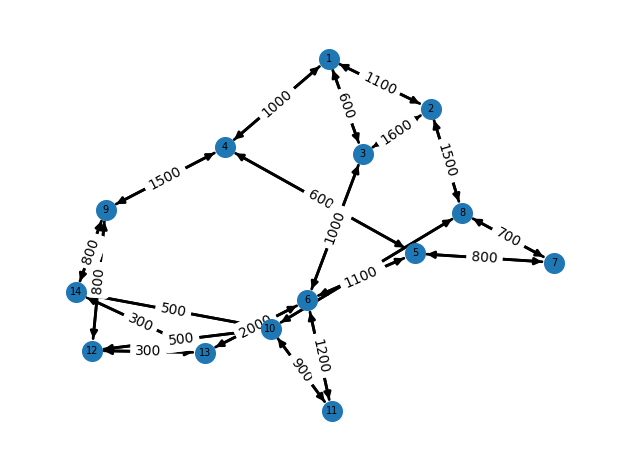

In [11]:
write = True

# Set the ASLC : ['ASSL', 'AWSL', SSL']
aslc = "ASSL"

# Modify: X_i, X_f, k, num_iter
num_iter = 100       # Average over
X_i = 600
X_f = 800
steps = int((X_f - X_i)/25 + 1)
X_range = np.arange(X_i, X_f+25, 25)

edges = nsfnet    # Choosing the network topology : [nsfnet, six_nodes]
topology = 'nsfnet'
dir_edges = edges + [(v, u, w) for (u, v, w) in edges]    # For bidirectional edges

# Creating the network topology(graph)
g = create_bi_topology(dir_edges) 
numNodes = len(g)

k = 1              # Given parameter
k_SP = dir_sp(g)    # Directed shortest paths for all node pairs

In [12]:
print(num_iter)
initialize = 'ODCN'
%run ./initialization.ipynb
%run ./Improvise.ipynb

100


SyntaxError: invalid syntax (1693762169.py, line 3)

SyntaxError: invalid syntax (1693762169.py, line 3)

In [ ]:
start_time = time.time()

print(f"Running QKRA-{aslc} for # CRs = {X_i} to {X_f} with {steps = }, {k = }, iterations = {num_iter}") 

total_runs = num_iter*steps

with tqdm.tqdm(total = total_runs, colour = 'blue', leave = True) as pbar:
    for z in range(num_iter):
        X = X_i    # Initial value of X
        step = 0    
        %run ./QKRA.ipynb    # Calling another file to allocate the resources

pbar.close()

print("\nSimulation Ended")

end_time = time.time()

In [ ]:
# To create dataframe for the description of CRs
%run ./cr_df.ipynb

In [ ]:
df.head()

In [ ]:
# figure, ax = plt.subplots(2, 2, figsize=(18, 12))
fig = plt.figure(constrained_layout=True, figsize=(13, 7))
gs = fig.add_gridspec(2, 4)  # 2 rows, 4 columns

axs = np.empty((2, 2), dtype = 'object')
# Large plots
axs[0, 0] = fig.add_subplot(gs[0, :])  # Spans both rows and the first 2 columns
axs[0, 0].set_xlabel('Number of CRs(X)')  # Set the x-axis label
axs[0, 0].set_ylabel('Counts')  # Set the y-axis label
axs[0, 0].set_title('Allocated and Blocked counts for each X')  # Set the title

axs[0, 1] = fig.add_subplot(gs[1, :2])  # Spans the first row and last 2 columns
axs[0, 1].set_xlabel('Number of CRs(X)')  # Set the x-axis label
axs[0, 1].set_ylabel('Counts')  # Set the y-axis label
axs[0, 1].set_title('Counts and Ratio trends')  # Set the title

axs01 = axs[0, 1].twinx()
sns.lineplot(x='X', y='ratio', hue='cr_status', data=status_count, linestyle='--', ax = axs01)
axs01.set_ylabel('Ratio', color='black')
axs01.tick_params(axis='y', labelcolor='black')
axs01.grid(True)

# Smaller plots
axs[1, 0] = fig.add_subplot(gs[1, 2])   # Occupies 2nd row, 3rd column
axs[1, 0].set_title('Counts vs SL')
axs[1, 0].set_xlabel('SL')  # Set the x-axis label
axs[1, 0].set_ylabel('Counts')  # Set the y-axis label

heatmap_data = df.groupby(['cr_sl', 'cr_status']).size().unstack(fill_value=0)
axs[1, 1] = fig.add_subplot(gs[1, 3])   # Occupies 2nd row, 4th column
axs[1, 1].set_title('SL vs Status')
axs[1, 1].set_ylabel('SL')  # Set the x-axis label
axs[1, 1].set_xlabel('Status')  # Set the x-axis label

fig.suptitle('Combined counts for all X', fontsize=14, x = 0.73, y=0.01)


sns.barplot(x='X', y='count', hue='cr_status', data=status_count, ax = axs[0, 0])
sns.lineplot(x='X', y='count', hue='cr_status', data=status_count, ax = axs[0, 1])
sns.countplot(data=df, x='cr_sl', hue='cr_status', ax = axs[1, 0])
sns.heatmap(heatmap_data, annot=True, cmap='Blues', ax = axs[1, 1])


handles, labels = axs[0, 1].get_legend_handles_labels()
color_legend = axs[0, 1].legend(handles=handles, labels=labels, title="CR Status", loc='lower right', bbox_to_anchor=(1., 0.004))
line_styles = [
    plt.Line2D([0], [0], color='gray', linestyle='-', label='Count'),
    plt.Line2D([0], [0], color='gray', linestyle='--', label='Ratio')
]
linestyle_legend = axs[0, 1].legend(handles=line_styles, title="Metric", loc='lower center', bbox_to_anchor=(0.65, 0.003))

# Add a box around the two smaller plots
# Adjust these coordinates according to your figure layout
left = 0.485  # X coordinate of the left side of the box
bottom = -0.025  # Y coordinate of the bottom side of the box
width = 0.52  # Width of the box
height = 0.525  # Height of the box

rect = matplotlib.patches.Rectangle((left, bottom), width, height, linewidth=2, edgecolor='black', facecolor='none')
fig.add_artist(rect)
axs[0, 1].add_artist(color_legend)
axs01.get_legend().remove()

print('CR Analysis')
plt.show()

In [ ]:
grouped_df.head(6)

In [ ]:
grouped_df.tail()

In [ ]:
status_count.head()

In [ ]:
# # Group by step and cr_sl
# cr_sl_grouped = grouped_df.groupby(['X', 'cr_sl', 'cr_status'])['count'].sum().unstack().reset_index().fillna(0)

# # Calculate the ratio and total for each cr_sl
# cr_sl_grouped['total'] = cr_sl_grouped['allocated'] + cr_sl_grouped['blocked']
# cr_sl_grouped['ratio'] = cr_sl_grouped['allocated'] / cr_sl_grouped['total']


# Plotting the trends for each cr_sl
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Allocated CRs trend by cr_sl
sns.lineplot(x='X', y='allocated', hue='cr_sl', data=cr_sl_grouped, marker='o', ax=axs[0])
axs[0].set_title('Allocated CRs')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Counts')

# Unallocated CRs trend by cr_sl
sns.lineplot(x='X', y='blocked', hue='cr_sl', data=cr_sl_grouped, marker='o', ax=axs[1])
axs[1].set_title('Blocked CRs')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Counts')

# Ratio trend by cr_sl
sns.lineplot(x='X', y='ratio', hue='cr_sl', data=cr_sl_grouped, marker='o', ax=axs[2])
axs[2].set_title('Ratio of Allocated CRs')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Ratio')

trend_title = 'Trend of CR status counts for each value of X'
fig.suptitle(trend_title, fontsize = 18)
print(trend_title)
plt.tight_layout()
plt.show()

# Calculation

In [ ]:
# Calculating the time taken by simulation

elapsed_time = f"{int((end_time - start_time)/3600)}h {int((end_time - start_time)/60 % 60)}m {(end_time - start_time)%60 : .2f}s"
print(f"Elapsed Time : {elapsed_time}")

In [ ]:
TSUR, NSP, SRCR    # Contains corrected quantities -> sim

In [ ]:
# Calculating the averages of different network metrics: NSP, SRCR, TUR (and Nsp, Allocated, TSUR)
%run ./avg_metrics.ipynb

In [ ]:
%matplotlib inline
### sim.fuzzy_scale(target, fuzzy = 'around', distr  = 'uniform')
### simulation.duplicate(target, distr = 'gaussian')
### fuzzy = Around by default

# 1. Averaged after correction
# 2. Duplicate : equivalent to fuzzy_scale('brute')
# 3. Real
# 4. Correction after average
# 5. Under

# 1
# for i in range(num_iter):
#     cr_corr = simulation(SRCR[i], TSUR[i], NSP[i])
#     cr_corr_avg = simulation.add(cr_corr_avg, cr_corr)

# cr_corr_avg.SRCR /= num_iter
# cr_corr_avg.TUR /= num_iter
# cr_corr_avg.NSP /= num_iter

cr_corr_avg = simulation(avg_SRCR, avg_TSUR, avg_NSP)

# 2
cr_brute = simulation.duplicate(paper.assl)
 
# 3 Real
cr_avg_real = simulation(avg_srcr, avg_tur, avg_nsp)

# 4 Corrected after average
cr_avg_corr = simulation(avg_srcr, avg_tur, avg_nsp)
cr_avg_corr.fuzzy_scale(paper.assl)

cr_under_corr = simulation(avg_srcr, avg_tur, avg_nsp)
cr_under_corr.fuzzy_scale(paper.assl, fuzzy = 'below')

dummy_srcr = [0.940275, 0.9207  , 0.91908 , 0.90272 , 0.8955  , 0.886333, 0.870861, 0.852576, 0.838092]
dummy_tur = [0.5773  , 0.58764 , 0.601975, 0.618268, 0.636724, 0.64845 , 0.666   , 0.666943, 0.68204 ]
dummy_nsp = [2316.93 , 2348.445, 2407.9  , 2499.96 , 2522.095, 2587.41 , 2621.825, 2648.64 , 2714.56 ]
mod = simulation(dummy_srcr, dummy_tur, dummy_nsp)

plot_comparision([mod, cr_corr_avg], labels = ['Paper', 'simulation'])
plot_comparision(set_ticks = False, objects = [mod, cr_corr_avg, cr_brute, cr_avg_real, cr_avg_corr, cr_under_corr], labels = ['mod', 'Correct-Average', 'Brute', 'Real', 'Average-Corrected', 'below'])
# # 4
# cr_assl_corrected = cr_assl
# correction = cr_assl_corrected.fuzzy_scale(paper.assl)

In [ ]:
plot_simulation(cr_corr_avg)
plot_comparision([cr_corr_avg], labels = ['Network data Run 8'])

In [ ]:
plot_simulation(cr_corr_avg)

In [ ]:
# %run ./Improvise.ipynb

zeros = np.zeros(len(X_range))
cr_corr_avg = simulation(zeros, zeros, zeros)
for i in range(num_iter):
    cr_corr = simulation(SRCR[i], TSUR[i], NSP[i])
    cr_corr.fuzzy_scale(paper.assl)
    cr_corr_avg = simulation.add(cr_corr_avg, cr_corr)

In [ ]:
cr_corr_avg.SRCR /= num_iter
cr_corr_avg.TUR /= num_iter
cr_corr_avg.NSP /= num_iter
# 
# plot_simulation(cr_corr_avg)

In [ ]:
plot_comparision([cr_corr_avg], ['corr_avg'])

In [ ]:
# %run ./Improvise.ipynb

cr_copy= simulation.duplicate(paper.assl)
# plot_simulation(cr_copy, set_ticks = False)
plot_comparision(cr_copy, paper.assl)

In [ ]:
correction = cr_copy.fuzzy_scale(paper.assl, 'brute')
# plot_simulation(cr_copy)
plot_comparision(cr_copy, paper.assl)
print(correction[0])

In [ ]:
# %run ./Improvise.ipynb
cr_assl = simulation(avg_srcr, avg_tur, avg_nsp)
cr_assl_corrected = simulation(avg_TSUR, avg_SRCR, avg_NSP)
# plot_comparision(cr_assl, paper.assl)
plot_comparision(cr_assl_avg, paper.assl)

In [ ]:
plot_comparision(cr_assl, paper.assl)

In [ ]:
cr_assl_corrected = cr_assl
correction = cr_assl_corrected.fuzzy_scale(paper.assl)

In [ ]:
plot_comparision(cr_assl_corrected)

In [ ]:
# Open the file to write data to
filename = f"QKRA-{aslc}({topology}).txt"
data_path = os.path.join(data_subdirectory, filename)

file = open(data_path, "a")
file.write(f"\n\nQKRA-{aslc}: {topology=}, k = {k}, Averaged over(z) = {num_iter} : \n")
file.write(f"\nX_range = [{', '.join(map(str, X_range))}] \nAverage_SRCR_{aslc} = [{', '.join(map(str, avg_srcr))}] \nAverage_TUR_{aslc} = [{', '.join(map(str, avg_tur))}] \nAverage_NSP_{aslc} = [{', '.join(map(str, avg_nsp))}]\n")
file.close()

# Display Data

In [ ]:
len(X_range), len(avg_srcr), len(avg_tur), len(avg_nsp), len(avg_TSUR), len(avg_SRCR), len(avg_NSP)

In [ ]:
print(f"Average SRCR : {avg_srcr}, \nAverage TUR : {avg_tur}, \nAverage NSP : {avg_nsp}, \nX : {X_range}")

# Plotting

Plot 1 : SRCR and TUR

Plot2 : NSP

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))    # 1 column for SRCR and TUR, another for NSP

ax1.scatter(X_range, avg_srcr, label='SRCR - scatter')     # [j_X_i:j_X_f+1]
ax1.scatter(X_range, avg_tur, label='TUR - scatter')    # [j_X_i:j_X_f+1]
ax2.scatter(X_range, avg_nsp, color = 'green')    # [j_X_i:j_X_f+1]

ax1.plot(X_range, avg_SRCR, label='SRCR - line')
ax1.plot(X_range, avg_TSUR, label='TUSR - line')
ax2.plot(X_range, avg_NSP, color = 'green')


ax1.set_xlabel('X = Number of CRs')
ax1.set_ylabel('Ratio')
ax1.set_title("SRCR and TUR")
ax1.minorticks_on()
ax1.legend(loc='best')

ax2.set_xlabel('X = Number of CRs')
ax2.set_ylabel('NSP')
ax2.set_title("NSP")
ax2.minorticks_on()

fig.suptitle(f"Network Evaluation for QKRA-{aslc} : averaged over {num_iter} iterations, k = {k}", y=1.05)  # Place title above subplots
# fig.legend()

# Show the plot
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Saving the plot
filename = (f"{aslc} - z = {num_iter}, k = {k} for X - {X_i} to {X_f}.jpeg")
print(filename)